In [43]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
from plot_tools import effect_size
import re
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14

### Make directory to save results:

In [44]:
resultsdir = '../results/N5_Combinatorial_Motif_Effects/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N5_Combinatorial_Motif_Effects/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load data:

In [45]:
data = sio.loadmat('../data/Reads.mat')

# A5SS
A5SS_data = data['A5SS']
A5SS_data = np.array(A5SS_data.todense())
# Get minigenes with reads
A5SS_nn = find(A5SS_data.sum(axis=1))
A5SS_data = A5SS_data[A5SS_nn]
A5SS_data = A5SS_data/A5SS_data.sum(axis=1)[:,newaxis]
A5SS_seqs = pd.read_csv('../data/A5SS_Seqs.csv',index_col=0).Seq[A5SS_nn]

# A3SS
A3SS_data = data['A3SS']
# Only look at SA_1 usage:
A3SS_data = np.array(A3SS_data[:,235].todense()).reshape(-1)/np.array(A3SS_data.sum(axis=1),dtype=np.float64).reshape(-1)
# Get minigenes with reads
A3SS_nn = find(pd.notnull(A3SS_data))
A3SS_data = A3SS_data[A3SS_nn]
A3SS_seqs = pd.read_csv('../data/A3SS_Seqs.csv',index_col=0).Seq[A3SS_nn]


### Calculate the number of expected non-overlapping 4-mer pairs within each 25nt random region

We will only look at non-overlapping pairs. Also we will take order into account (ie: GGGT-AAAC is different than AAAC-GGGT). If we consider the 5' 4-mers that occur in the first random position, there are 25-4-4+1=18 other positions for non overlapping 3' 4-mers. If the 5' 4-mer occurs in the second position there will be 17 positions for the 3' 4-mer and so on.

In [46]:
print '4-mer pairs per 25nt region:',sum(range(1,19))

4-mer pairs per 25nt region: 171


In [47]:
print '4-mer pair counts (Average) in A5SS:',sum(range(1,19))*len(A5SS_seqs)/((4**4.)**2)
print '4-mer pair counts (Average) in A3SS:',sum(range(1,19))*len(A3SS_seqs)/((4**4.)**2)

4-mer pair counts (Average) in A5SS: 691.566833496
4-mer pair counts (Average) in A3SS: 4399.45092773


Compute the pairwise effects for each 4-mer combination in each random region of each library<br>
This is also fairly computationally intensive so I have written and run python scripts for this<br>
../bin/combinatorial_effect_size_A3SS_R1.py<br>
../bin/combinatorial_effect_size_A3SS_R2.py<br>
../bin/combinatorial_effect_size_A5SS_R1.py<br>
../bin/combinatorial_effect_size_A5SS_R2.py<br>
They can be run with the following (with mer_len as an option)
cd bin
python combinatorial_effect_size_A3SS_R1.py 4

Load the results of the scripts:

In [48]:
A5SS_comb_df = pd.read_pickle('../results/N5_Combinatorial_Motif_Effects/A5SS/comb_effects_mer_R1.df')
A3SS_comb_df = pd.read_pickle('../results/N5_Combinatorial_Motif_Effects/A3SS/comb_effects_mer_R2.df')

Now we calculate the individual effects of 4-mers within random region 1 of the A5SS library:

In [49]:
# This has already been run and saved, so just load the data
precalculated = True
if precalculated:
    mer_effects_A5 = pd.read_pickle('../results/N5_Combinatorial_Motif_Effects/A5SS/Individual_Mer4_Effects.pd')
    ordered_inds = mer_effects_A5.order().index
else:
    mer4 = make_mer_list(4)
    mer_effects_A5 = {}
    for mer in mer4:
        found = deg_seqs.str.contains(mer)
        found_splicing = data[found.values].mean()
        not_found_splicing = data[found.values==False].mean()
        mer_effects_A5[mer] = log2(found_splicing/(1.-found_splicing)) -\
                              log2(not_found_splicing/(1.-not_found_splicing))
        print mer,
    mer_effects_A5 = pd.Series(mer_effects_A5).order()
    ordered_inds = mer_effects_A5.index
    mer_effects_A5.to_pickle('../results/N5_Combinatorial_Motif_Effects/A5SS/Individual_Mer4_Effects.pd')

Calculate the predicted pairwise effects according to a simple additive model:

In [50]:
A5_pred_arr = np.zeros((len(ordered_inds),len(ordered_inds)))
for i in range(len(ordered_inds)):
    for j in range(len(ordered_inds)):
        A5_pred_arr[i,j] = mer_effects_A5.ix[ordered_inds[i]]+mer_effects_A5.ix[ordered_inds[j]]

Plot the pairwise effects for the model, the data, and the difference between the two:

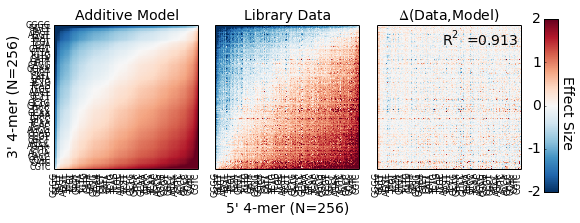

In [51]:
fsize = 14
fig = figure(figsize=(8,4))
ax = fig.add_axes([0,0.3,0.25,1])
imshow(A5_pred_arr,interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
ax.set_ylabel('3\' 4-mer (N=256)',fontsize=fsize)
ax.set_title('Additive Model',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A5))[::6])
ax.set_xticklabels(mer_effects_A5.index[::6],fontsize=8,rotation=90);
ax.set_yticks(arange(0,len(mer_effects_A5))[::6])
ax.set_yticklabels(mer_effects_A5.index[::6],fontsize=8,rotation=0);
ax.tick_params(size=0)

ax = fig.add_axes([0.28,0.3,0.25,1])
imshow(A5SS_comb_df.ix[ordered_inds,ordered_inds],interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
#ax.set_xlabel('5\' 6-mer',fontsize=fsize)
#ax.set_ylabel('3\' 6-mer',fontsize=fsize)
ax.set_title('Library Data',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A5))[::6])
ax.set_xticklabels(mer_effects_A5.index[::6],fontsize=8,rotation=90);
ax.tick_params(size=0)
ax.set_xlabel('5\' 4-mer (N=256)',fontsize=fsize)


ax = fig.add_axes([0.56,0.3,0.25,1])
cax = imshow(A5SS_comb_df.ix[ordered_inds,ordered_inds]-A5_pred_arr,
       interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
#ax.set_xlabel('5\' 6-mer',fontsize=fsize)
#ax.set_ylabel('3\' 6-mer',fontsize=fsize)
ax.set_title('$\Delta$(Data,Model)',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A5))[::6])
ax.set_xticklabels(mer_effects_A5.index[::6],fontsize=8,rotation=90);
ax.tick_params(size=0)
r,p = scipy.stats.pearsonr(A5_pred_arr.reshape(-1),A5SS_comb_df.ix[ordered_inds,ordered_inds].values.reshape(-1))
ax.text(256*0.98,256*0.02,'$R^2=%0.3f$' %r**2,fontsize=fsize,ha='right',va='top')

ax = fig.add_axes([0.85,0.47,0.025,0.6])
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.RdBu_r,
                                   norm=norm,
                                   orientation='vertical')
ax.yaxis.set_tick_params(labelsize=14)
ax.yaxis.set_ticks(arange(0,1.01,1/4.))
ax.yaxis.set_ticklabels([-2,-1,0,1,2])
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.text(1.6,0.25,'Effect Size',ha='center',va='bottom',rotation=-90,fontsize=14)
#ax.set_ylabel('$(log_2\ odds-ratio)$',fontsize=14,rotation=-90)
ax.tick_params(size=2)

if True:
    filename = 'A5SS_comb_4mer'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=300)

### Make the plots for the A3SS lib:

In [52]:
# This has already been run and saved, so just load the data
precalculated = True
if precalculated:
    mer_effects_A3 = pd.read_pickle('../results/N5_Combinatorial_Motif_Effects/A3SS/Individual_Mer4_Effects.pd')
    ordered_inds = mer_effects_A3.order().index
else:
    mer4 = make_mer_list(4)
    mer_effects_A3 = {}
    for mer in mer4:
        found = deg_seqs.str.contains(mer)
        found_splicing = data[found.values].mean()
        not_found_splicing = data[found.values==False].mean()
        mer_effects_A3[mer] = log2(found_splicing/(1.-found_splicing)) - log2(not_found_splicing/(1.-not_found_splicing))
        print mer,
    mer_effects_A3 = pd.Series(mer_effects_A3).order()
    ordered_inds = mer_effects_A3.index
    mer_effects_A3.to_pickle('../results/N5_Combinatorial_Motif_Effects/A3SS/Individual_Mer4_Effects.pd')

Calculate the predicted pairwise effects according to a simple additive model:

In [53]:
A3_pred_arr = np.zeros((len(ordered_inds),len(ordered_inds)))
for i in range(len(ordered_inds)):
    for j in range(len(ordered_inds)):
        A3_pred_arr[i,j] = mer_effects_A3.ix[ordered_inds[i]]+mer_effects_A3.ix[ordered_inds[j]]
    print i,

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255


Plot the pairwise effects for the model, the data, and the difference between the two:

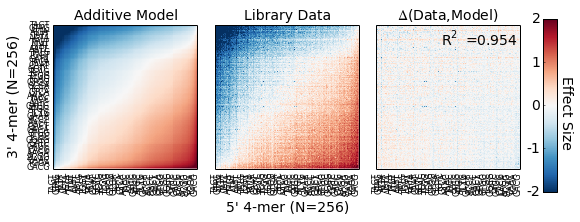

In [54]:
fsize = 14
fig = figure(figsize=(8,4))
ax = fig.add_axes([0,0.3,0.25,1])
imshow(A3_pred_arr,interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
ax.set_ylabel('3\' 4-mer (N=256)',fontsize=fsize)
ax.set_title('Additive Model',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A3))[::6])
ax.set_xticklabels(mer_effects_A3.index[::6],fontsize=8,rotation=90);
ax.set_yticks(arange(0,len(mer_effects_A3))[::6])
ax.set_yticklabels(mer_effects_A3.index[::6],fontsize=8,rotation=0);
ax.tick_params(size=0)

ax = fig.add_axes([0.28,0.3,0.25,1])
imshow(A3SS_comb_df.ix[ordered_inds,ordered_inds],interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
#ax.set_xlabel('5\' 6-mer',fontsize=fsize)
#ax.set_ylabel('3\' 6-mer',fontsize=fsize)
ax.set_title('Library Data',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A3))[::6])
ax.set_xticklabels(mer_effects_A3.index[::6],fontsize=8,rotation=90);
ax.tick_params(size=0)
ax.set_xlabel('5\' 4-mer (N=256)',fontsize=fsize)


ax = fig.add_axes([0.56,0.3,0.25,1])
cax = imshow(A3SS_comb_df.ix[ordered_inds,ordered_inds]-A3_pred_arr,
       interpolation='None',vmin=-2,vmax=2,cmap=cm.RdBu_r)
ax.xaxis.set_ticklabels([]);
ax.yaxis.set_ticklabels([]);
#ax.set_xlabel('5\' 6-mer',fontsize=fsize)
#ax.set_ylabel('3\' 6-mer',fontsize=fsize)
ax.set_title('$\Delta$(Data,Model)',fontsize=fsize)
ax.set_xticks(arange(0,len(mer_effects_A3))[::6])
ax.set_xticklabels(mer_effects_A3.index[::6],fontsize=8,rotation=90);
ax.tick_params(size=0)
r,p = scipy.stats.pearsonr(A3_pred_arr.reshape(-1),A3SS_comb_df.ix[ordered_inds,ordered_inds].values.reshape(-1))
ax.text(256*0.98,256*0.02,'$R^2=%0.3f$' %r**2,fontsize=fsize,ha='right',va='top')

ax = fig.add_axes([0.85,0.47,0.025,0.6])
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.RdBu_r,
                                   norm=norm,
                                   orientation='vertical')
ax.yaxis.set_tick_params(labelsize=14)
ax.yaxis.set_ticks(arange(0,1.01,1/4.))
ax.yaxis.set_ticklabels([-2,-1,0,1,2])
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.text(1.6,0.25,'Effect Size',ha='center',va='bottom',rotation=-90,fontsize=14)
#ax.set_ylabel('$(log_2\ odds-ratio)$',fontsize=14,rotation=-90)
ax.tick_params(size=2)

if True:
    filename = 'A3SS_comb_4mer'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=300)

In [ ]:
dnatools